In [1]:
# Loading the required libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [6]:
# Listing all the terms and corresponding filenames
search_terms = {
    "flu_symptoms": "flu_symptoms.csv",
    "cough": "cough.csv",
    "fever": "fever.csv",
    "sore_throat": "sore_throat.csv",
    "runny_nose": "runny_nose.csv",
    "flu_medicine": "flu_medicine.csv",
    "flu_shot": "flu_shot.csv",
    "flu_vaccine": "flu_vaccine.csv",
    "cold_vs_flu": "cold_vs_flu.csv",
    "body_aches": "body_aches.csv",
    "tiredness": "tiredness.csv",
    "how_to_treat_flu": "how_to_treat_flu.csv"
}

# Defining a function for loading and cleaning each CSV
def load_and_clean(filepath, keyword):
    # Reading the file while skipping the first two rows for headers
    df = pd.read_csv(filepath, skiprows=2)
    
    # Renaming the columns to a standard format
    df.columns = ['Week', keyword]
    
    # Converting 'Week' to datetime format
    df['Week'] = pd.to_datetime(df['Week'], errors='coerce')
    
    # Converting values to numeric, coercing errors into NaN
    df[keyword] = pd.to_numeric(df[keyword], errors='coerce')
    
    return df

# Initializing merged DataFrame
merged_df = None

# Iterating through each file and merging them on 'Week'
for term, filename in search_terms.items():
    df = load_and_clean(filename, term)
    
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='Week', how='outer')

# Sorting the merged DataFrame by Week and removing any rows with missing values
merged_df = merged_df.sort_values('Week').dropna().reset_index(drop=True)

# Displaying the cleaned and merged dataset
print(merged_df.head())


        Week  flu_symptoms  cough  fever  sore_throat  runny_nose  \
0 2020-05-10             9     27     39           28          30   
1 2020-05-17             9     26     35           26          27   
2 2020-05-24             8     23     35           26          23   
3 2020-05-31             7     21     32           22          23   
4 2020-06-07             7     22     33           27          26   

   flu_medicine  flu_shot  flu_vaccine  cold_vs_flu  body_aches  tiredness  \
0             6         6           26           11          24         80   
1             4         5           21           11          22         78   
2             4         3           16           10          21         71   
3             5         2            8            9          20         77   
4             5         2            9           11          21         76   

   how_to_treat_flu  
0                 7  
1                 8  
2                 7  
3                 6  
4     

In [7]:
# Saving the cleaned and merged dataset to a new CSV file
merged_df.to_csv("flu_merged_data.csv", index=False)

In [8]:
# Setting the relevant parameters
target_col = 'flu_symptoms'
max_lag = 4

# Creating a copy of the dataset to work on
df_lagged = merged_df.copy()

# Creating lagged features for each predictor by excluding the target variable
for col in merged_df.columns:
    if col != 'Week' and col != target_col:
        for lag in range(1, max_lag + 1):
            lagged_col_name = f"{col}_lag{lag}"
            df_lagged[lagged_col_name] = merged_df[col].shift(lag)

# Dropping rows with NaNs caused by lagging
df_lagged = df_lagged.dropna().reset_index(drop=True)

# Viewing the resulting dataset
print(df_lagged.head())

# Saving the lagged dataset for further use
df_lagged.to_csv("flu_lagged_data.csv", index=False)
print("Lagged dataset saved to 'flu_lagged_data.csv'")


        Week  flu_symptoms  cough  fever  sore_throat  runny_nose  \
0 2020-06-07             7     22     33           27          26   
1 2020-06-14             8     24     37           29          30   
2 2020-06-21             9     27     41           34          36   
3 2020-06-28            11     28     45           40          42   
4 2020-07-05             9     28     46           43          45   

   flu_medicine  flu_shot  flu_vaccine  cold_vs_flu  ...  body_aches_lag3  \
0             5         2            9           11  ...             22.0   
1             5         3           10           10  ...             21.0   
2             7         3           12           13  ...             20.0   
3             7         4           17           15  ...             21.0   
4             7         3           14           17  ...             26.0   

   body_aches_lag4  tiredness_lag1  tiredness_lag2  tiredness_lag3  \
0             24.0            77.0            71.0  

In [9]:
# Selecting target vector
y = df_lagged['flu_symptoms'].values

# Selecting lagged predictor columns only that have '_lag' in the starting of the name
feature_cols = [col for col in df_lagged.columns if '_lag' in col]
X = df_lagged[feature_cols].values

# Viewing the shape of design matrix and target to verify
print(f"Design matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")


Design matrix X shape: (258, 44)
Target vector y shape: (258,)


In [10]:
import cvxpy as cp

# Defining the ridge regression solver using the CVXPY
def solve_ridge(X, y, lambda_val, penalty_start=0):
    n, p = X.shape
    
    # Defining the coefficient vector as a CVXPY variable
    beta = cp.Variable(p)
    
    # Defining the Ridge loss function with L2 penalty
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    
    # Setting up and solving the optimization problem
    objective = cp.Minimize(loss + reg)
    problem = cp.Problem(objective)
    problem.solve()
    
    return beta.value

# Defining Lasso regression solver using CVXPY
def solve_lasso(X, y, lambda_val, penalty_start=0):
    n, p = X.shape
    
    # Defining the coefficient vector as a CVXPY variable
    beta = cp.Variable(p)
    
    # Defining the Lasso loss function with L1 penalty
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    
    # Setting up and solving the optimization problem
    objective = cp.Minimize(loss + reg)
    problem = cp.Problem(objective)
    problem.solve()
    
    return beta.value


In [11]:
# Defining manual 5-fold cross-validation for the Ridge regression
def ridge_cv(X, y, lambda_candidates, penalty_start=0):
    n = len(y)
    cv_errors = {lamb: 0.0 for lamb in lambda_candidates}

    # Creating folds (rotating indices)
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val=lamb, penalty_start=penalty_start)
            y_pred = X_test @ beta
            cv_errors[lamb] += np.sum((y_test - y_pred) ** 2)

    # Averaging the total squared errors over all data points
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n

    best_lambda = min(cv_errors, key=cv_errors.get)
    return best_lambda, cv_errors


In [12]:
# Defining the manual 5-fold cross-validation for Lasso regression
def lasso_cv(X, y, lambda_candidates, penalty_start=0):
    n = len(y)
    cv_errors = {lamb: 0.0 for lamb in lambda_candidates}

    # Creating folds (rotating indices)
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        for lamb in lambda_candidates:
            beta = solve_lasso(X_train, y_train, lambda_val=lamb, penalty_start=penalty_start)
            y_pred = X_test @ beta
            cv_errors[lamb] += np.sum((y_test - y_pred) ** 2)

    # Averaging the total squared errors over all data points
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n

    best_lambda = min(cv_errors, key=cv_errors.get)
    return best_lambda, cv_errors


In [13]:
# Defining a range of different of the lambda values to try
lambda_candidates = np.array([0.01, 0.1, 1, 10, 100, 1000])

# Running Ridge CV
best_lambda_ridge, ridge_errors = ridge_cv(X, y, lambda_candidates)
print(f"Best lambda for Ridge: {best_lambda_ridge}")
print("Ridge CV Errors:")
for lamb, err in ridge_errors.items():
    print(f"  Lambda = {lamb:.2f}, CV Error = {err:.4f}")

Best lambda for Ridge: 1000.0
Ridge CV Errors:
  Lambda = 0.01, CV Error = 24.5352
  Lambda = 0.10, CV Error = 24.5322
  Lambda = 1.00, CV Error = 24.5020
  Lambda = 10.00, CV Error = 24.2193
  Lambda = 100.00, CV Error = 22.5161
  Lambda = 1000.00, CV Error = 20.5865


In [14]:
# Running Lasso CV
best_lambda_lasso, lasso_errors = lasso_cv(X, y, lambda_candidates)
print(f"\nBest lambda for Lasso: {best_lambda_lasso}")
print("Lasso CV Errors:")
for lamb, err in lasso_errors.items():
    print(f"  Lambda = {lamb:.2f}, CV Error = {err:.4f}")


Best lambda for Lasso: 100.0
Lasso CV Errors:
  Lambda = 0.01, CV Error = 24.5349
  Lambda = 0.10, CV Error = 24.5292
  Lambda = 1.00, CV Error = 24.4730
  Lambda = 10.00, CV Error = 23.9481
  Lambda = 100.00, CV Error = 21.0977
  Lambda = 1000.00, CV Error = 21.9132


In [15]:
# Fitting final Ridge model using the best lambda
beta_ridge = solve_ridge(X, y, lambda_val=best_lambda_ridge)

# Calculating fitted values
fitted_ridge = X @ beta_ridge

In [16]:
# Fitting final Lasso model using the best lambda
beta_lasso = solve_lasso(X, y, lambda_val=best_lambda_lasso)

# Calculating fitted values
fitted_lasso = X @ beta_lasso

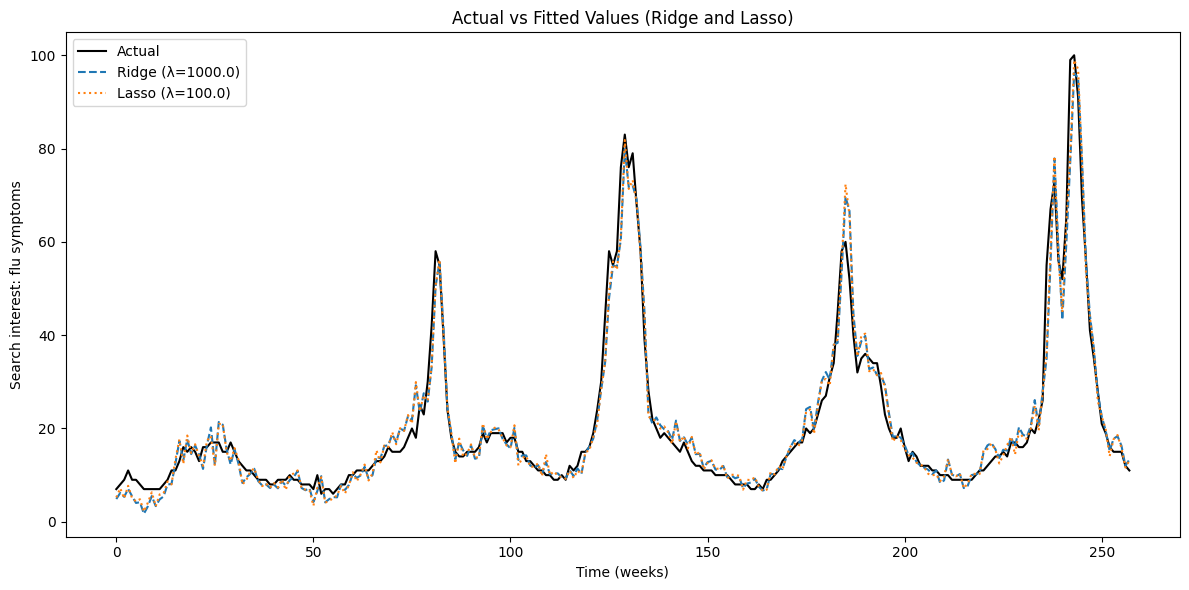

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y, label="Actual", color="black")
plt.plot(fitted_ridge, label=f"Ridge (λ={best_lambda_ridge})", linestyle="--")
plt.plot(fitted_lasso, label=f"Lasso (λ={best_lambda_lasso})", linestyle=":")
plt.title("Actual vs Fitted Values (Ridge and Lasso)")
plt.xlabel("Time (weeks)")
plt.ylabel("Search interest: flu symptoms")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Getting nonzero coefficients from Lasso
threshold = 1e-6
nonzero_idx = np.where(np.abs(beta_lasso) > threshold)[0]

print("Non-zero Lasso Coefficients:")
for i in nonzero_idx:
    print(f"{feature_cols[i]}: {beta_lasso[i]:.4f}")


Non-zero Lasso Coefficients:
cough_lag1: -0.2544
cough_lag2: -0.1950
cough_lag3: 0.2956
cough_lag4: 0.1423
fever_lag1: 0.0819
fever_lag2: -0.0695
fever_lag3: -0.0082
sore_throat_lag2: -0.3296
sore_throat_lag3: 0.3144
sore_throat_lag4: -0.0165
runny_nose_lag1: 0.0706
runny_nose_lag2: -0.0779
runny_nose_lag3: -0.0175
flu_medicine_lag1: 0.6071
flu_medicine_lag2: -0.1238
flu_medicine_lag4: -0.1916
flu_shot_lag1: -0.0349
flu_shot_lag2: 0.0195
flu_shot_lag3: 0.0184
flu_shot_lag4: 0.0081
flu_vaccine_lag2: 0.0524
flu_vaccine_lag3: 0.0017
cold_vs_flu_lag1: 0.1805
cold_vs_flu_lag2: -0.0029
cold_vs_flu_lag3: -0.0134
cold_vs_flu_lag4: -0.1062
body_aches_lag1: 0.1994
body_aches_lag2: -0.0548
body_aches_lag3: -0.0344
tiredness_lag2: 0.0271
tiredness_lag3: -0.0834
tiredness_lag4: 0.0229
how_to_treat_flu_lag1: 0.6259
how_to_treat_flu_lag2: 0.0003
how_to_treat_flu_lag3: -0.2462
how_to_treat_flu_lag4: 0.1887


In [21]:
def evaluate_model(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
evaluate_model(y, fitted_ridge, name="Ridge")
evaluate_model(y, fitted_lasso, name="Lasso")


Ridge - RMSE: 3.8135, MAE: 2.4993, R²: 0.9529
Lasso - RMSE: 3.6731, MAE: 2.4650, R²: 0.9563


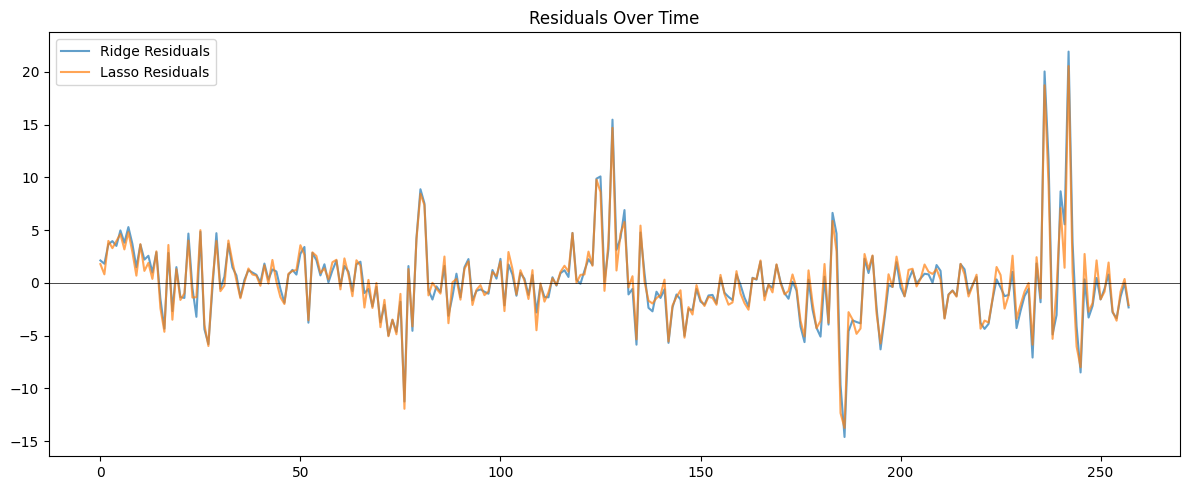

In [22]:
residuals_ridge = y - fitted_ridge
residuals_lasso = y - fitted_lasso

plt.figure(figsize=(12, 5))
plt.plot(residuals_ridge, label="Ridge Residuals", alpha=0.7)
plt.plot(residuals_lasso, label="Lasso Residuals", alpha=0.7)
plt.axhline(0, color="black", linewidth=0.5)
plt.title("Residuals Over Time")
plt.legend()
plt.tight_layout()
plt.show()


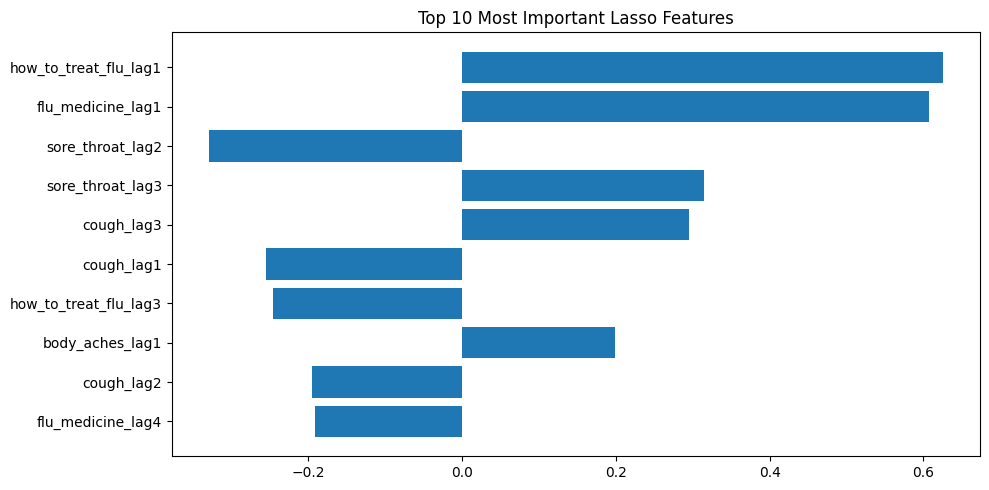

In [23]:
# Getting sorted coefficient magnitudes from Lasso
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "lasso_coef": beta_lasso
})
coef_df["abs_val"] = coef_df["lasso_coef"].abs()
top_features = coef_df.sort_values("abs_val", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_features["feature"], top_features["lasso_coef"])
plt.title("Top 10 Most Important Lasso Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


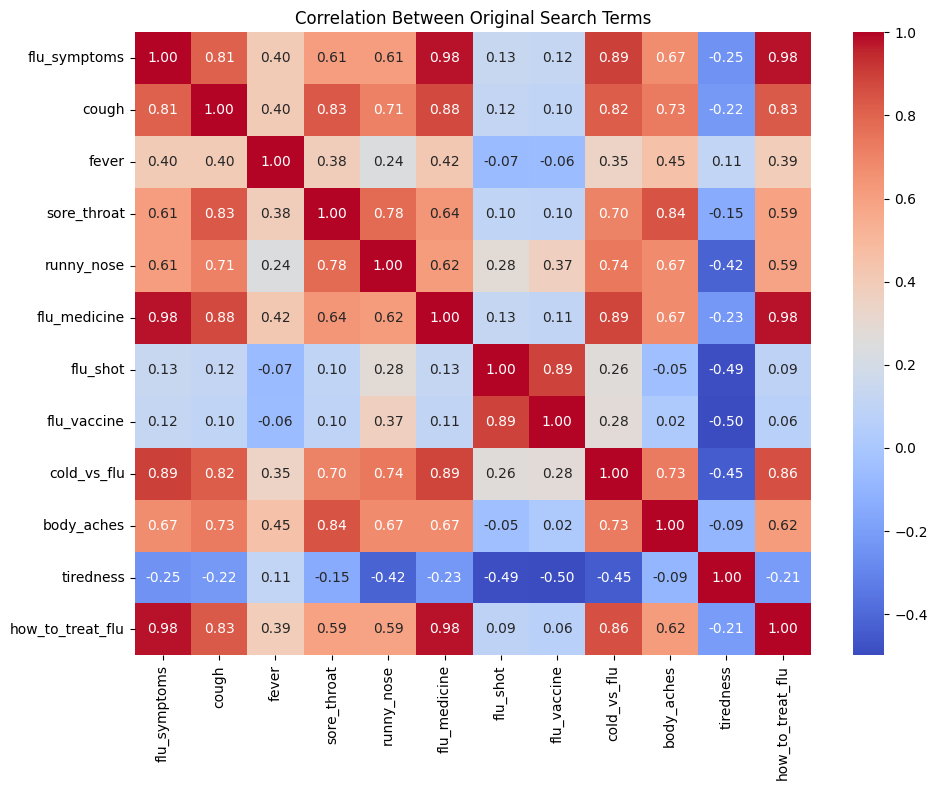

In [24]:
# Using non-lagged variables only
non_lagged = merged_df.drop(columns=["Week"])
plt.figure(figsize=(10, 8))
sns.heatmap(non_lagged.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Original Search Terms")
plt.tight_layout()
plt.show()


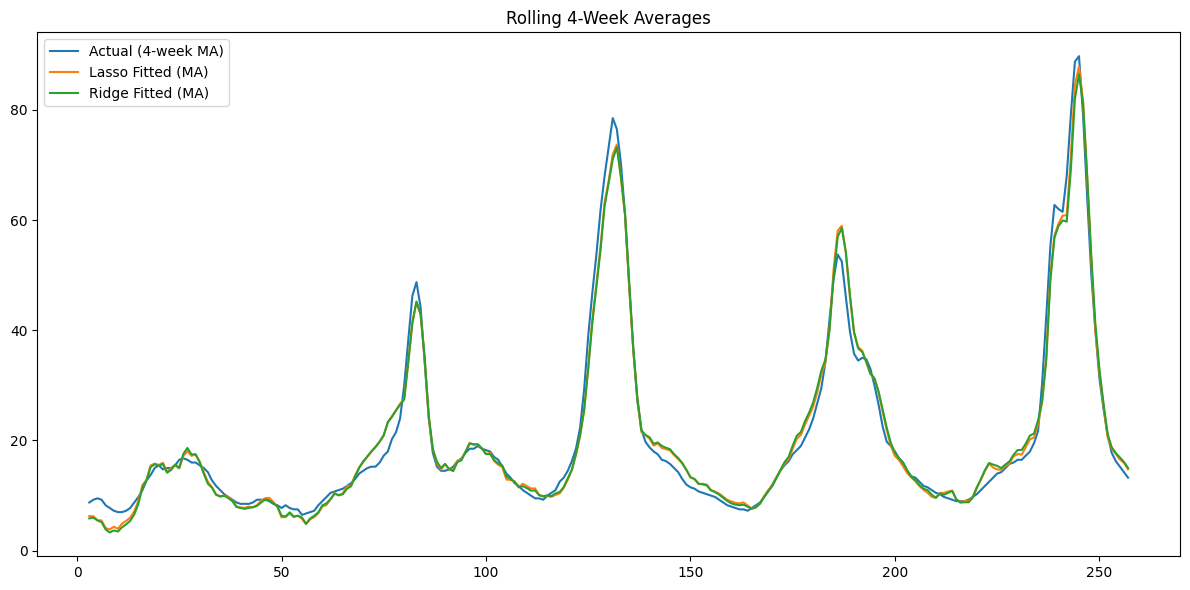

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(y).rolling(4).mean(), label="Actual (4-week MA)")
plt.plot(pd.Series(fitted_lasso).rolling(4).mean(), label="Lasso Fitted (MA)")
plt.plot(pd.Series(fitted_ridge).rolling(4).mean(), label="Ridge Fitted (MA)")
plt.title("Rolling 4-Week Averages")
plt.legend()
plt.tight_layout()
plt.show()


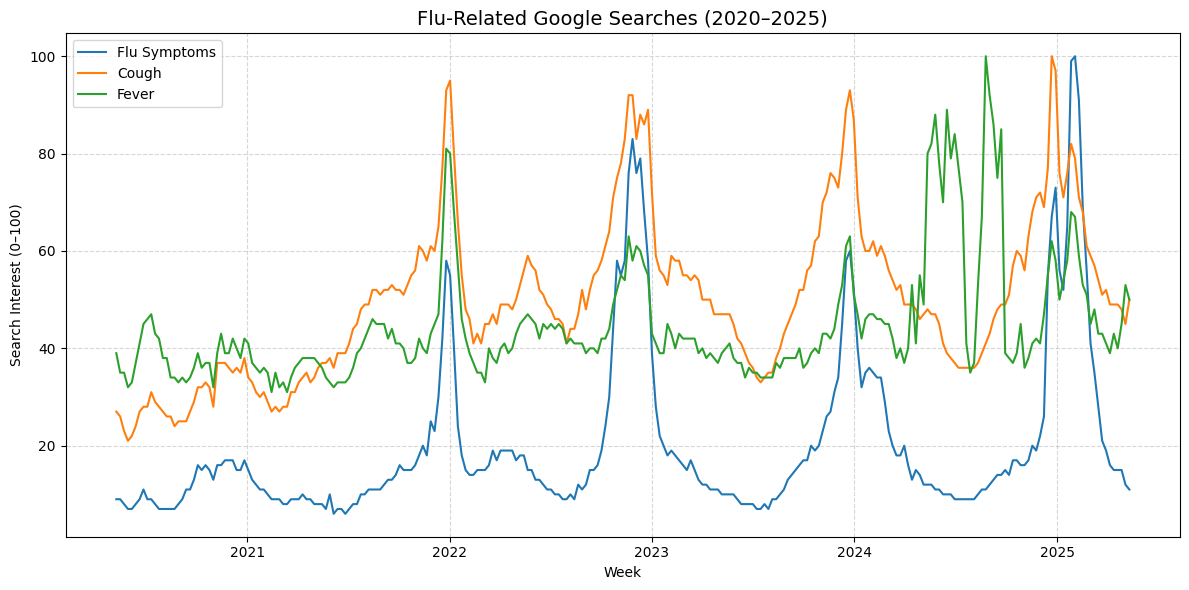

In [26]:
# Choosing only 3 terms
columns_to_plot = ['flu_symptoms', 'cough', 'fever']

# Creating the plot
plt.figure(figsize=(12, 6))

for col in columns_to_plot:
    plt.plot(merged_df['Week'], merged_df[col], label=col.replace('_', ' ').title())

plt.title("Flu-Related Google Searches (2020–2025)", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Search Interest (0–100)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:
merged_df.head()

,Week,flu_symptoms,cough,fever,sore_throat,runny_nose,flu_medicine,flu_shot,flu_vaccine,cold_vs_flu,body_aches,tiredness,how_to_treat_flu
0,2020-05-10,9,27,39,28,30,6,6,26,11,24,80,7
1,2020-05-17,9,26,35,26,27,4,5,21,11,22,78,8
2,2020-05-24,8,23,35,26,23,4,3,16,10,21,71,7
3,2020-05-31,7,21,32,22,23,5,2,8,9,20,77,6
4,2020-06-07,7,22,33,27,26,5,2,9,11,21,76,5
